# Install/import related packages

In [66]:
# the code works in Python 3.6.
!pip install simpletransformers

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/opt/rh/rh-python36/root/usr/bin/python3 -m pip install --upgrade pip' command.


# Set the global varibles
These varibles are task-specific and are used in the whole process.

In [67]:
# Data related
data_dir = '/labs/sarkerlab/yguo262/simpletransformers/data/natal_sex/data_splits_1'              # the folder that stores train.csv, dev.csv, and test.csv
out_dir = './model'              # where the trained model will be stored
pred_out_file = f'{out_dir}/preds.csv'

# Task related
classes = ['F', 'M']          # the classes list 

# Model related
sliding_window_flag = 0          # whether the sliding window is used or not
max_epoch = 10                    # how many epochs for training


# Load the train, dev, and test dataset
When loading the datasets, if the labels are not numbers, we need to convert the text labels into numbers.
Also, the model output will be numbers rather than text labels.

In [68]:
import pandas as pd

'''
Load data from the csv file and convert into the format that the model can read.

@params:
    dat_file:   the csv file
    is_train:   whether the csv file is a training set
    sep:        the deliminator for the csv file (default is the comma)
    text_name:  the columne name of the text column in the csv file 
    label_name: the columne name of the label column in the csv file 
    classes:    the list of all classes
    label_map:  whether the label needs to be mapped into a number

@return: a DataFrame with the `text` and `labels` column
'''
def load_data(
    dat_file,
    is_train=False,
    sep=',',
    text_name='text',
    label_name='label',
    classes = [],
    label_map = False
    ):

    df = pd.read_csv(dat_file, usecols=[text_name, label_name], sep=sep)

    # if it is a training set, do random shuffling
    if is_train:
        df = df.sample(frac=1).reset_index(drop=True)

    df = df.dropna()
    df = df.rename(columns={label_name:'labels'}) # the label name for the model is defaultly set as "labels"
    print(df.head())

    # If the label is text, it needs to be converted into numbers.
    # We used the index of the classes list as the new labels. 
    # For example, if the classes are ['F', 'M'], all 'F' labels are mapped into 0, and the left are mapped into 1.
    if label_map:        
        df['labels'] = df['labels'].apply(classes.index)

        print('after mapping:')
        print(df.head())
    
    print('size:', len(df))    
    return df

In [69]:
df_train = load_data(f'{data_dir}/train.csv', is_train=True, classes=classes, label_map=True)

                                                text labels
0  NA@@@(kw_male=1, kw_fem=0, 0 days from index d...      M
1  (kw_male=1, kw_fem=0, -4742 days from index da...      F
2  (kw_male=4, kw_fem=0, 0 days from index date) ...      M
3  (kw_male=0, kw_fem=1, -131 days from index dat...      F
4  (kw_male=8, kw_fem=0, 0 days from index date) ...      M
after mapping:
                                                text  labels
0  NA@@@(kw_male=1, kw_fem=0, 0 days from index d...       1
1  (kw_male=1, kw_fem=0, -4742 days from index da...       0
2  (kw_male=4, kw_fem=0, 0 days from index date) ...       1
3  (kw_male=0, kw_fem=1, -131 days from index dat...       0
4  (kw_male=8, kw_fem=0, 0 days from index date) ...       1
size: 3936


In [70]:
df_val = load_data(f'{data_dir}/dev.csv', is_train=False, classes=classes, label_map=True)

                                                text labels
0  (kw_male=3, kw_fem=0, -780 days from index dat...      M
1  (kw_male=2, kw_fem=2, 437 days from index date...      F
2  (kw_male=0, kw_fem=3, 48 days from index date)...      F
3  (kw_male=2, kw_fem=0, -3854 days from index da...      M
4  (kw_male=0, kw_fem=1, -1030 days from index da...      F
after mapping:
                                                text  labels
0  (kw_male=3, kw_fem=0, -780 days from index dat...       1
1  (kw_male=2, kw_fem=2, 437 days from index date...       0
2  (kw_male=0, kw_fem=3, 48 days from index date)...       0
3  (kw_male=2, kw_fem=0, -3854 days from index da...       1
4  (kw_male=0, kw_fem=1, -1030 days from index da...       0
size: 984


In [71]:
df_test = load_data(f'{data_dir}/test.csv', is_train=False, classes=classes, label_map=True)

                                                text labels
0  (kw_male=3, kw_fem=7, 529 days from index date...      F
1  (kw_male=0, kw_fem=1, -449 days from index dat...      F
2  (kw_male=1, kw_fem=2, 791 days from index date...      F
3  (kw_male=2, kw_fem=0, -535 days from index dat...      M
4  (kw_male=1, kw_fem=7, 48 days from index date)...      F
after mapping:
                                                text  labels
0  (kw_male=3, kw_fem=7, 529 days from index date...       0
1  (kw_male=0, kw_fem=1, -449 days from index dat...       0
2  (kw_male=1, kw_fem=2, 791 days from index date...       0
3  (kw_male=2, kw_fem=0, -535 days from index dat...       1
4  (kw_male=1, kw_fem=7, 48 days from index date)...       0
size: 1230


# Model training

## Set up the hyper-parameters

In [72]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs

model_args = ClassificationArgs()

# model architecture
model_args.sliding_window = sliding_window_flag
model_args.max_seq_length = 512
model_args.train_batch_size = 32
model_args.num_train_epochs = max_epoch

# input data process
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True

# save checkpoints
model_args.best_model_dir = f'{out_dir}/best_model' # the best model will be stored
model_args.evaluate_during_training = True

# early stopping config
model_args.use_early_stopping = True                 # stop training if the loss does not change for several steps


## Create a classification model
The class `ClassificationModel` is used to create the model, and the model is initialized from `roberta`.

In [73]:
model = ClassificationModel("roberta", "roberta-base", num_labels=len(classes), use_cuda=True, args=model_args) 

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

## Start training the model

In [74]:
model.train_model(df_train, eval_df=df_val, output_dir=out_dir)

/opt/rh/rh-python36/root/usr/lib64/python3.6/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/opt/rh/rh-python36/root/usr/lib64/python3.6/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/opt/rh/rh-python36/root/usr/lib64/python3.6/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/opt/rh/rh-python36/root/usr/lib64/python3.6/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/opt/rh/rh-python36/root/usr/lib64/python3.6/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
/opt/rh/rh-python36/root/usr/lib64/python3.6/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/opt/rh/rh-python36/root/usr/lib64/python3.6/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/opt/rh/rh-python36/root/usr/lib64/python3.6/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/opt/rh/rh-python36/root/usr/lib64/python3.6/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/opt/rh/rh-python36/root/usr/lib64/python3.6/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(1230,
 {'global_step': [123, 246, 369, 492, 615, 738, 861, 984, 1107, 1230],
  'tp': [349, 383, 342, 386, 400, 398, 395, 404, 403, 401],
  'tn': [530, 542, 548, 546, 541, 542, 545, 543, 542, 542],
  'fp': [27, 15, 9, 11, 16, 15, 12, 14, 15, 15],
  'fn': [78, 44, 85, 41, 27, 29, 32, 23, 24, 26],
  'mcc': [0.7842255151504345,
   0.8785837845696924,
   0.8119576401912432,
   0.8932926467470126,
   0.9110181684328605,
   0.9090150780912166,
   0.9092673162593922,
   0.9234329476931182,
   0.9192847713839193,
   0.9151689772459158],
  'train_loss': [0.241390198469162,
   0.1408456265926361,
   0.16624797880649567,
   0.11160486191511154,
   0.08506438881158829,
   0.2549882233142853,
   0.01762290671467781,
   0.0007679288974031806,
   0.002141338074579835,
   0.00043367783655412495],
  'eval_loss': [0.2636372587545131,
   0.14471004447877045,
   0.22785996128918556,
   0.17888843802057539,
   0.1345393094111128,
   0.1619942379283446,
   0.21016437926602255,
   0.21341947600166447,
   0.2

# Model inference/prediction
After training, we can make the model predict on the testing set.
The output consists of the prediction and the vector of logits. The vecter size is the same as the number of classes.

In machine learning, logits are interpreted to be the unnormalised predictions of a model. We apply softmax to it to get a probability distribution over the classes.

Note that if the sliding window is applied, the model will output a matrix instead of a vector of logits for each case. Each row of the matrix is the logit vector for that window of text.

In [75]:
test_text = df_test['text']
predictions, raw_outputs = model.predict(test_text)
print('predictions:\n', predictions)
print('logits:\n', raw_outputs)


predictions:
 [0 0 0 ... 0 1 0]
logits:
 [[ 4.61328125 -4.515625  ]
 [ 4.77734375 -4.6484375 ]
 [ 4.734375   -4.609375  ]
 ...
 [ 4.65234375 -4.51171875]
 [-4.4375      4.33984375]
 [ 1.20214844 -1.17089844]]


In [76]:
import numpy as np
def softmax(x, axis=None):
    x = x - x.max(axis=axis, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=axis, keepdims=True)

logits = np.asarray(raw_outputs)
probas = softmax(logits, axis=1)
print('normalized logits:\n', probas)

normalized logits:
 [[9.99891528e-01 1.08472407e-04]
 [9.99919388e-01 8.06120944e-05]
 [9.99912497e-01 8.75029976e-05]
 ...
 [9.99895274e-01 1.04725572e-04]
 [1.54163331e-04 9.99845837e-01]
 [9.14748767e-01 8.52512331e-02]]


In [77]:
# store the predictions to a csv file seperated by '\t'
with open(pred_out_file, 'w') as fw:
    fw.write('index\tprediction\n')
    for i, pred in enumerate(predictions):
        fw.write(f'{i}\t{pred}\n')

# Model evaluation

In [78]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
test_labels = df_test['labels'] 
report = classification_report(test_labels, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       697
           1       0.95      0.93      0.94       533

    accuracy                           0.95      1230
   macro avg       0.95      0.94      0.95      1230
weighted avg       0.95      0.95      0.95      1230



# Plot the confusion matrix

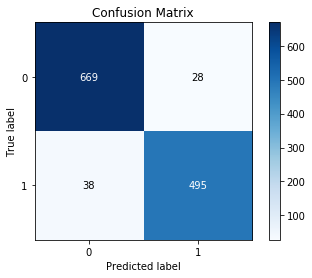

--------------------------


In [79]:
import scikitplot
import matplotlib.pyplot as plt
cm = confusion_matrix(test_labels, predictions)
scikitplot.metrics.plot_confusion_matrix(test_labels, predictions)
plt.show()

print('--------------------------')
